# Readmittance Analysis for Diabetes Patients

## Install and import Pyspark and load data from CSV file

In [1]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 52 kB/s 
     |████████████████████████████████| 199 kB 66.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=47b736ffac576b881fe87a46d9d86df9cc765a4a5ae2e2145bf07fb27181a80c
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [2]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SparkSession

In [64]:
file_path = 'diabetic_data.csv'

spark = SparkSession.builder.appName('Semester Project - Diabetes Data Analysis').getOrCreate()

df = spark.read.csv(file_path, header=True, inferSchema=True, nullValue='?')
df.show(5)

+------------+-----------+---------------+------+-------+------+-----------------+------------------------+-------------------+----------------+----------+--------------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|           race|gender|    age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|   medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnos

## Exploratory Data Analysis and cleaning

In [4]:
df.printSchema()

root
 |-- encounter_id: integer (nullable = true)
 |-- patient_nbr: integer (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- weight: string (nullable = true)
 |-- admission_type_id: integer (nullable = true)
 |-- discharge_disposition_id: integer (nullable = true)
 |-- admission_source_id: integer (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- payer_code: string (nullable = true)
 |-- medical_specialty: string (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- diag_1: string (nullable = true)
 |-- diag_2: string (nullable = true)
 |-- diag_3: string (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-

In [5]:
print('Rows:',df.count())
print('Columns:',len(df.columns))

Rows: 101766
Columns: 50


In [6]:
# Get the number of null values in each column
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------------+-----------+----+------+---+------+-----------------+------------------------+-------------------+----------------+----------+-----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+
|encounter_id|patient_nbr|race|gender|age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin

In [7]:
df.groupBy('weight').count().show()

+---------+-----+
|   weight|count|
+---------+-----+
|[150-175)|   35|
|[125-150)|  145|
|     null|98569|
|   [0-25)|   48|
|  [25-50)|   97|
| [75-100)| 1336|
|[175-200)|   11|
|[100-125)|  625|
|     >200|    3|
|  [50-75)|  897|
+---------+-----+



In [8]:
df.groupBy('encounter_id').count().count()

101766

In [9]:
df.groupBy('patient_nbr').count().count()

71518

In [10]:
df.groupBy('payer_code').count().orderBy('count',ascending=False).show()

+----------+-----+
|payer_code|count|
+----------+-----+
|      null|40256|
|        MC|32439|
|        HM| 6274|
|        SP| 5007|
|        BC| 4655|
|        MD| 3532|
|        CP| 2533|
|        UN| 2448|
|        CM| 1937|
|        OG| 1033|
|        PO|  592|
|        DM|  549|
|        CH|  146|
|        WC|  135|
|        OT|   95|
|        MP|   79|
|        SI|   55|
|        FR|    1|
+----------+-----+



In [11]:
df.groupBy('medical_specialty').count().orderBy('count',ascending=False).show()

+--------------------+-----+
|   medical_specialty|count|
+--------------------+-----+
|                null|49949|
|    InternalMedicine|14635|
|    Emergency/Trauma| 7565|
|Family/GeneralPra...| 7440|
|          Cardiology| 5352|
|     Surgery-General| 3099|
|          Nephrology| 1613|
|         Orthopedics| 1400|
|Orthopedics-Recon...| 1233|
|         Radiologist| 1140|
|         Pulmonology|  871|
|          Psychiatry|  854|
|             Urology|  685|
|ObstetricsandGyne...|  671|
|Surgery-Cardiovas...|  652|
|    Gastroenterology|  564|
|    Surgery-Vascular|  533|
|       Surgery-Neuro|  468|
|PhysicalMedicinea...|  391|
|            Oncology|  348|
+--------------------+-----+
only showing top 20 rows



In [12]:
df.groupBy('diag_1').count().orderBy('count',ascending=False).show()

+------+-----+
|diag_1|count|
+------+-----+
|   428| 6862|
|   414| 6581|
|   786| 4016|
|   410| 3614|
|   486| 3508|
|   427| 2766|
|   491| 2275|
|   715| 2151|
|   682| 2042|
|   434| 2028|
|   780| 2019|
|   996| 1967|
|   276| 1889|
|    38| 1688|
| 250.8| 1680|
|   599| 1595|
|   584| 1520|
|   V57| 1207|
| 250.6| 1183|
|   518| 1115|
+------+-----+
only showing top 20 rows



Encounter ID is unique to each column. Patient number is an identifier unique to each patient. Weight, payer code, and medical specialty have too many missing values, and it is unclear what the diag columns mean. These will be dropped from analysis.

In [13]:
# Drop unnecessary columns
for c in ['encounter_id','patient_nbr','weight','payer_code','medical_specialty','diag_1','diag_2','diag_3']:
  df = df.drop(c)
df.printSchema()

root
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- admission_type_id: integer (nullable = true)
 |-- discharge_disposition_id: integer (nullable = true)
 |-- admission_source_id: integer (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-- max_glu_serum: string (nullable = true)
 |-- A1Cresult: string (nullable = true)
 |-- metformin: string (nullable = true)
 |-- repaglinide: string (nullable = true)
 |-- nateglinide: string (nullable = true)
 |-- chlorpropamide: string (nullable = true)
 |-- glimepiride: string (nullable = true)
 |-- acetohexamide: string (nulla

In [14]:
# Drop rows with null values
df = df.dropna()
df.count()

99493

In [15]:
# Describe numeric features
int_cols = ['admission_type_id','discharge_disposition_id','admission_source_id','time_in_hospital','num_procedures','num_lab_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses']
str_cols = [c for c in df.columns if c not in int_cols]
df.select(int_cols).describe().show()

+-------+------------------+------------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+
|summary| admission_type_id|discharge_disposition_id|admission_source_id|  time_in_hospital|    num_procedures|num_lab_procedures|   num_medications| number_outpatient|   number_emergency|  number_inpatient|  number_diagnoses|
+-------+------------------+------------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+
|  count|             99493|                   99493|              99493|             99493|             99493|             99493|             99493|             99493|              99493|             99493|             99493|
|   mean|2.0272481481109224|       3.740856140633009| 5.7709487099594945| 4.398419989345984|

In [16]:
# Get the number of unique values for each categorical column
for s in str_cols:
  print(s,df.groupBy(s).count().count())

race 5
gender 3
age 10
max_glu_serum 4
A1Cresult 4
metformin 4
repaglinide 4
nateglinide 4
chlorpropamide 4
glimepiride 4
acetohexamide 2
glipizide 4
glyburide 4
tolbutamide 2
pioglitazone 4
rosiglitazone 4
acarbose 4
miglitol 4
troglitazone 2
tolazamide 3
examide 1
citoglipton 1
insulin 4
glyburide-metformin 4
glipizide-metformin 2
glimepiride-pioglitazone 2
metformin-rosiglitazone 1
metformin-pioglitazone 2
change 2
diabetesMed 2
readmitted 3


In [17]:
# Show the distribution of values for each categorical column
for s in str_cols:
  df.groupBy(s).count().orderBy('count',ascending=False).show()

+---------------+-----+
|           race|count|
+---------------+-----+
|      Caucasian|76099|
|AfricanAmerican|19210|
|       Hispanic| 2037|
|          Other| 1506|
|          Asian|  641|
+---------------+-----+

+---------------+-----+
|         gender|count|
+---------------+-----+
|         Female|53575|
|           Male|45917|
|Unknown/Invalid|    1|
+---------------+-----+

+--------+-----+
|     age|count|
+--------+-----+
| [70-80)|25469|
| [60-70)|21988|
| [50-60)|16895|
| [80-90)|16800|
| [40-50)| 9465|
| [30-40)| 3699|
|[90-100)| 2724|
| [20-30)| 1611|
| [10-20)|  682|
|  [0-10)|  160|
+--------+-----+

+-------------+-----+
|max_glu_serum|count|
+-------------+-----+
|         None|94203|
|         Norm| 2571|
|         >200| 1466|
|         >300| 1253|
+-------------+-----+

+---------+-----+
|A1Cresult|count|
+---------+-----+
|     None|82897|
|       >8| 7961|
|     Norm| 4905|
|       >7| 3730|
+---------+-----+

+---------+-----+
|metformin|count|
+---------+-----+

In [18]:
# Admission type, discharge disposition, and admission source are categorical columns that have already been indexed.
# See if any of these correlate to the target
target = 'readmitted'
cat_cols = ['admission_type_id','discharge_disposition_id','admission_source_id']
for c in cat_cols:
  df.groupBy(c).pivot(target).count().orderBy(c).show(30)

+-----------------+----+-----+-----+
|admission_type_id| <30|  >30|   NO|
+-----------------+----+-----+-----+
|                1|6122|19003|27775|
|                2|2009| 6345| 9432|
|                3|1940| 5666|10902|
|                4|   1|    2|    7|
|                5| 491| 1708| 2528|
|                6| 579| 2200| 2446|
|                7|null| null|   20|
|                8|  27|   83|  207|
+-----------------+----+-----+-----+

+------------------------+----+-----+-----+
|discharge_disposition_id| <30|  >30|   NO|
+------------------------+----+-----+-----+
|                       1|5515|21186|32067|
|                       2| 333|  659| 1069|
|                       3|1990| 4818| 6806|
|                       4|  97|  270|  398|
|                       5| 238|  339|  566|
|                       6|1622| 5295| 5781|
|                       7|  90|  219|  302|
|                       8|  15|   38|   54|
|                       9|   9|    2|   10|
|                      10|n

In [19]:
for c in cat_cols:
  df.groupBy(c).count().orderBy('count').show(30)

+-----------------+-----+
|admission_type_id|count|
+-----------------+-----+
|                4|   10|
|                7|   20|
|                8|  317|
|                5| 4727|
|                6| 5225|
|                2|17786|
|                3|18508|
|                1|52900|
+-----------------+-----+

+------------------------+-----+
|discharge_disposition_id|count|
+------------------------+-----+
|                      20|    2|
|                      12|    3|
|                      27|    5|
|                      10|    6|
|                      19|    8|
|                      16|   11|
|                      17|   14|
|                       9|   21|
|                      24|   48|
|                      15|   63|
|                       8|  107|
|                      28|  138|
|                      14|  369|
|                      13|  397|
|                      23|  406|
|                       7|  611|
|                       4|  765|
|                      25| 

The dataset includes information on the ID mappings for admission type, admission source, and discharge disposition. Count how many rows map to NULL in these categories.

In [20]:
df.filter(df.admission_type_id == 6).count()

5225

In [21]:
df.filter(df.discharge_disposition_id == 18).count()

3673

In [22]:
df.filter(df.admission_source_id == 17).count()

6698

In [23]:
df = df.filter(df.admission_type_id != 6)
df = df.filter(df.discharge_disposition_id != 18)
df = df.filter(df.admission_source_id != 17)
df.count()

86833

In [24]:
# Drop rows with outliers and columns that only contain a single value
thresh = 100
for c in str_cols + cat_cols:
  if c in df.columns:
    grouped_df = df.groupBy(c).count().collect()
    unique = len(grouped_df)

    for row in grouped_df:
      row_dict = row.asDict(True)
      val = row_dict[c]
      count = row_dict['count']
      if count < thresh:
        df = df.filter(df[c] != val)
        unique -= 1

    if unique == 1:
      df = df.drop(c)
  print(c)

df.count()

race
gender
age
max_glu_serum
A1Cresult
metformin
repaglinide
nateglinide
chlorpropamide
glimepiride
acetohexamide
glipizide
glyburide
tolbutamide
pioglitazone
rosiglitazone
acarbose
miglitol
troglitazone
tolazamide
examide
citoglipton
insulin
glyburide-metformin
glipizide-metformin
glimepiride-pioglitazone
metformin-rosiglitazone
metformin-pioglitazone
change
diabetesMed
readmitted
admission_type_id
discharge_disposition_id
admission_source_id


85905

In [25]:
len(df.columns)

30

## Data visualizations

In [26]:
df.printSchema()

root
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- admission_type_id: integer (nullable = true)
 |-- discharge_disposition_id: integer (nullable = true)
 |-- admission_source_id: integer (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-- max_glu_serum: string (nullable = true)
 |-- A1Cresult: string (nullable = true)
 |-- metformin: string (nullable = true)
 |-- repaglinide: string (nullable = true)
 |-- nateglinide: string (nullable = true)
 |-- glimepiride: string (nullable = true)
 |-- glipizide: string (nullable = true)
 |-- glyburide: string (nullable = tru

Graph A1Cresult, insulin, and diabetesMed to show any correlation with readmission

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plot_df1 = df.groupBy('A1Cresult').pivot('readmitted').count().fillna(0).toPandas()
plot_df1

,A1Cresult,<30,>30,NO
0,None,8142,25317,37702
1,>8,679,2398,3823
2,Norm,427,1455,2622
3,>7,334,1151,1855


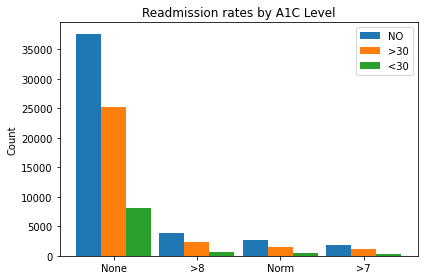

In [50]:
fig,ax = plt.subplots()
labels = list(plot_df1['A1Cresult'])
less30 = list(plot_df1['<30'])
greater30 = list(plot_df1['>30'])
no = list(plot_df1['NO'])

x = np.arange(len(labels))
width = 0.3

rects1 = ax.bar(x-0.3,no,width,label='NO')
rects2 = ax.bar(x,greater30,width,label='>30')
rects3 = ax.bar(x+0.3,less30,width,label='<30')

ax.set_ylabel('Count')
ax.set_title('Readmission rates by A1C Level')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.savefig('a1clevel')
plt.show()

In [29]:
plot_df2 = df.groupBy('insulin').pivot('readmitted').count().fillna(0).toPandas()
plot_df2

,insulin,<30,>30,NO
0,Steady,2953,9175,14639
1,Up,1288,3847,4820
2,No,3840,13095,21527
3,Down,1501,4204,5016


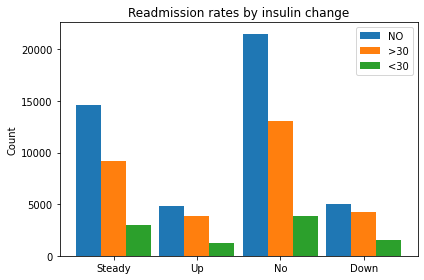

In [51]:
fig,ax = plt.subplots()
labels = list(plot_df2['insulin'])
less30 = list(plot_df2['<30'])
greater30 = list(plot_df2['>30'])
no = list(plot_df2['NO'])

x = np.arange(len(labels))
width = 0.3

rects1 = ax.bar(x-0.3,no,width,label='NO')
rects2 = ax.bar(x,greater30,width,label='>30')
rects3 = ax.bar(x+0.3,less30,width,label='<30')

ax.set_ylabel('Count')
ax.set_title('Readmission rates by insulin change')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.savefig('insulin')
plt.show()

In [54]:
plot_df3 = df.groupBy('diabetesMed').pivot('readmitted').count().fillna(0).toPandas()
plot_df3

,diabetesMed,<30,>30,NO
0,No,1822,5949,11418
1,Yes,7760,24372,34584


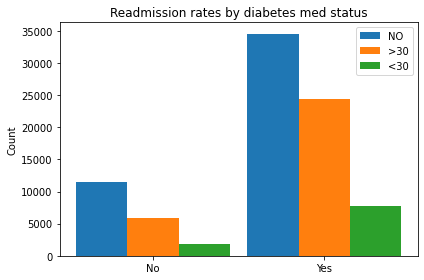

In [55]:
fig,ax = plt.subplots()
labels = list(plot_df3['diabetesMed'])
less30 = list(plot_df3['<30'])
greater30 = list(plot_df3['>30'])
no = list(plot_df3['NO'])

x = np.arange(len(labels))
width = 0.3

rects1 = ax.bar(x-0.3,no,width,label='NO')
rects2 = ax.bar(x,greater30,width,label='>30')
rects3 = ax.bar(x+0.3,less30,width,label='<30')

ax.set_ylabel('Count')
ax.set_title('Readmission rates by diabetes med status')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.savefig('diabetesmed')
plt.show()

## Prepare dataframe for model building

In [33]:
str_cols = [s for s in str_cols if s in df.columns and s != target]
print(len(int_cols)+len(str_cols))

29


In [34]:
# Admission type, discharge disposition, and admission source are all categorical that have already been converted to numeric codes. 
# These will need to be one-hot encoded. Cast the values to floats.
int_cols = [c for c in int_cols if c not in cat_cols]

for c in cat_cols:
  df = df.withColumn(c,df[c].cast(DecimalType()))

In [35]:
from pyspark.ml.feature import StringIndexer,OneHotEncoder,VectorAssembler
from pyspark.ml import Pipeline

# Apply String Indexing and One Hot Encoding, and assemble vectors

# Indexer includes only string cols
ind_cols = [x + "_index" for x in str_cols]
string_indexer = StringIndexer(inputCols=str_cols, outputCols=ind_cols) 

# OHE includes string and int categorical cols
encoder = OneHotEncoder(inputCols=string_indexer.getOutputCols() + cat_cols, outputCols=[x + "_OHE" for x in str_cols+cat_cols]) 

label_to_index = StringIndexer(inputCol=target,outputCol='label')

assembler_inputs = [c+'_OHE' for c in str_cols+cat_cols] + int_cols
vec_assembler = VectorAssembler(inputCols = assembler_inputs,outputCol='features')

indexer_pipeline = Pipeline(stages=[string_indexer,encoder,label_to_index,vec_assembler])
indexed_df = indexer_pipeline.fit(df).transform(df)

indexed_df.show(5)

+---------------+------+-------+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+----------------+-------------+---------+---------+-----------+-----------+-----------+---------+---------+------------+-------------+--------+-------+-------------------+------+-----------+----------+----------+------------+---------+-------------------+---------------+---------------+-----------------+-----------------+-----------------+---------------+---------------+------------------+-------------------+--------------+-------------+-------------------------+------------+-----------------+-------------+-------------+-------------+-----------------+-------------+-------------+---------------+---------------+---------------+-------------+-------------+----------------+-----------------+-------------+-------------+-----------------------+-------------+---------------+-------

In [36]:
# Apply PCA
from pyspark.ml.feature import PCA

pca = PCA(k=3,inputCol='features',outputCol='pca_features')
indexed_df = pca.fit(indexed_df).transform(indexed_df)
indexed_df.show(5)

+---------------+------+-------+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+----------------+-------------+---------+---------+-----------+-----------+-----------+---------+---------+------------+-------------+--------+-------+-------------------+------+-----------+----------+----------+------------+---------+-------------------+---------------+---------------+-----------------+-----------------+-----------------+---------------+---------------+------------------+-------------------+--------------+-------------+-------------------------+------------+-----------------+-------------+-------------+-------------+-----------------+-------------+-------------+---------------+---------------+---------------+-------------+-------------+----------------+-----------------+-------------+-------------+-----------------------+-------------+---------------+-------

In [37]:
# Split the data into training, test sets
SEED = 25

train_df,test_df = indexed_df.randomSplit([0.8,0.2],seed=SEED)
print(train_df.cache().count())
print(test_df.count())

68788
17117


## Build the models

In [38]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier

lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

lr_pca = LogisticRegression(featuresCol='pca_features')
dt_pca = DecisionTreeClassifier(featuresCol='pca_features')
rf_pca = RandomForestClassifier(featuresCol='pca_features')

In [39]:
lr_df = lr.fit(train_df).transform(test_df)
dt_df = dt.fit(train_df).transform(test_df)
rf_df = rf.fit(train_df).transform(test_df)

lr_pca_df = lr_pca.fit(train_df).transform(test_df)
dt_pca_df = dt_pca.fit(train_df).transform(test_df)
rf_pca_df = rf_pca.fit(train_df).transform(test_df)

In [40]:
lr_df.select('label','prediction','probability').show(5)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  1.0|       1.0|[0.36899175012589...|
|  0.0|       0.0|[0.71792547479820...|
|  0.0|       0.0|[0.65564936339654...|
|  2.0|       0.0|[0.58418100935890...|
|  0.0|       0.0|[0.69906300245150...|
+-----+----------+--------------------+
only showing top 5 rows



In [41]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
accuracy_evaluator = MulticlassClassificationEvaluator()

print('Logistic Regression')
print('Accuracy without PCA:',accuracy_evaluator.evaluate(lr_df))
print('Accuracy with PCA:',accuracy_evaluator.evaluate(lr_pca_df))
print('')

print('Decision Tree')
print('Accuracy without PCA:',accuracy_evaluator.evaluate(dt_df))
print('Accuracy with PCA:',accuracy_evaluator.evaluate(dt_pca_df))
print('')

print('Random Forest')
print('Accuracy without PCA:',accuracy_evaluator.evaluate(rf_df))
print('Accuracy with PCA:',accuracy_evaluator.evaluate(rf_pca_df))

Logistic Regression
Accuracy without PCA: 0.5175458006598406
Accuracy with PCA: 0.37191823654696315

Decision Tree
Accuracy without PCA: 0.5186313165345451
Accuracy with PCA: 0.37194358468509675

Random Forest
Accuracy without PCA: 0.42769988167760153
Accuracy with PCA: 0.3716816632861615


All three classifiers seemed to perform poorly, and the PCA actually made the predictions worse. Random Forest performed the worst, and Decision Tree barely outperformed Logistic Regression.

## Evaluation

In [56]:
# Show Confusion Matrix for each model
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
import matplotlib.pyplot as plt

def show_confusion_matrix(pred_df,filename):
  preds_and_labels = pred_df.select(['prediction','label'])
  metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
  matrix = metrics.confusionMatrix().toArray()

  sns.heatmap(matrix, annot=True,cmap='crest')
  plt.xlabel('Prediction')
  plt.ylabel('True')

  plt.savefig(filename)
  plt.show()

In [43]:
indexed_df.groupby('readmitted','label').count().show()

+----------+-----+-----+
|readmitted|label|count|
+----------+-----+-----+
|       <30|  2.0| 9582|
|       >30|  1.0|30321|
|        NO|  0.0|46002|
+----------+-----+-----+



/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


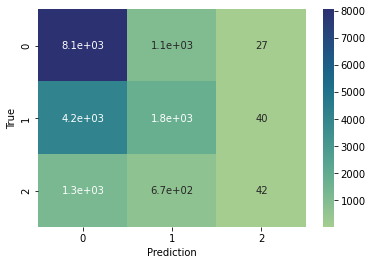

In [57]:
show_confusion_matrix(lr_df,'logisticregression')

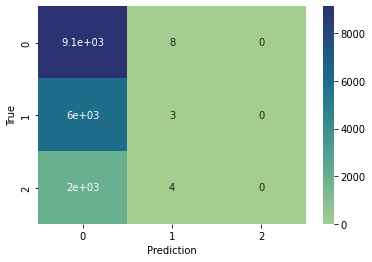

In [63]:
show_confusion_matrix(lr_pca_df,'logisticregressionpca')

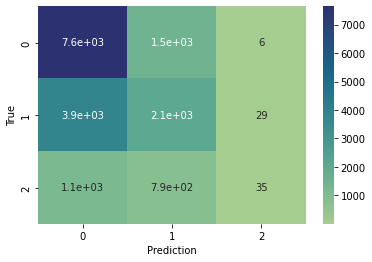

In [59]:
show_confusion_matrix(dt_df,'decisiontree')

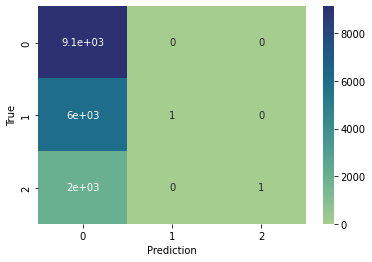

In [60]:
show_confusion_matrix(dt_pca_df,'decisiontreepca')

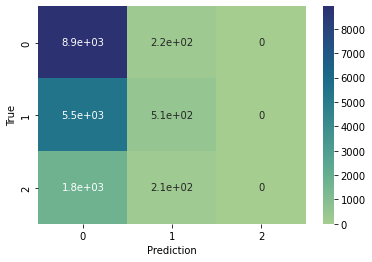

In [61]:
show_confusion_matrix(rf_df,'randomforest')

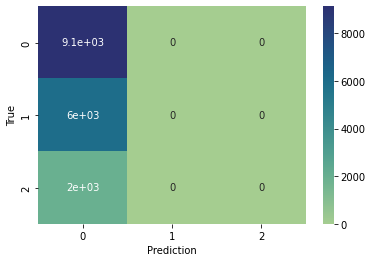

In [62]:
show_confusion_matrix(rf_pca_df,'randomforestpca')